In [1]:
import bregnn.ffwd as ffwd 
import bregnn.kin as kin 

Using TensorFlow backend.


In [2]:
import bregnn.io as io
reload(io)

<module 'bregnn.io' from '/users/musella/HHbbgg_ETH/bregression/notebooks/bregnn/io.py'>

In [3]:
import os

jetvars = ['recoJet2p5Energy',
           'recoJet2p5Pt',
           'recoJet2p5Eta',
           'recoJet2p5Phi',
           'recoJet2p5Pujetidmva',
           'recoJet2p5Px',
           'recoJet2p5Py',
           'recoJet2p5Pz']

jets = [  [var+ijet for var in jetvars ] for ijet in ['0','1','2','3','4','5']  ]

linv = ['recoJet2p5P0P1',
        'recoJet2p5P0P2',
        'recoJet2p5P0P3',
        'recoJet2p5P0P4',
        'recoJet2p5P0P5',
        'recoJet2p5P1P2',
        'recoJet2p5P1P3',
        'recoJet2p5P1P4',
        'recoJet2p5P1P5',
        'recoJet2p5P2P3',
        'recoJet2p5P2P4',
        'recoJet2p5P2P5',
        'recoJet2p5P3P4',
        'recoJet2p5P3P5',
        'recoJet2p5P4P5',
        'recoJet2p5Mass20',
        'recoJet2p5Mass21',
        'recoJet2p5Mass22',
        'recoJet2p5Mass23',
        'recoJet2p5Mass24',
        'recoJet2p5Mass25']

lep = ['recoPt','recoEta','recoPhi','recoPx', 'recoPy' ]

met = ['recoMETAllPt','recoMETAllPhi','recoMETAllPx','recoMETAllPy']

target = 'genJet2p5Mass201'

from functools import reduce
alljets = reduce(lambda x,y: x+y, jets)

columns = alljets+lep+met+linv+[target,'processIndex','genNjets2p5','recoNjets2p5','recoJet2p5Mass201']
base_dir = os.environ['SCRATCH'] + '/kinfit'

data = io.read_data(base_dir+'/kin_fit_input.hd5', columns = columns )

# for var in linv+[target]:
#     data[var] /= data['recoJet2p5Mass201']

data[target] /= data['recoJet2p5Mass201']
data[target] = np.sqrt(data[target])

In [4]:
data = data[(data.processIndex == 11) & (data.genNjets2p5 >= 2) & (data.recoNjets2p5 >= 2) ]#  & (data.recoPt > 100.) ]


# data[linv] = data[linv].fillna(0.)



# data.describe().T

In [5]:
# reload(ffwd)

# X0 = data[ linv ].values
# y0 = np.sqrt( data['recoJet2p5Mass201'].values )

# y0 -= np.median(y0)
# y0 /= y0.std()

# X0 -= np.median(X0)
# X0 /= X0.std()

# reload(ffwd)
# mreg = ffwd.FFWDRegression('mreg',X0.shape[1:],do_bn0=False,loss='mse',layers=[128]*3+[64,32],dropout=None)

# mmodel = mreg(True)

# mmodel.fit(X0,y0,epochs=50)

In [15]:
reload(ffwd)
reload(kin)

# features = alljets+lep+met+linv
# X = data[features].values

Xjets = np.concatenate([ data[jet].values.reshape(data.shape[0],1,-1) for jet in jets ],axis=-2)
Xev = data[lep+met].values
Xlinv = data[linv].values

Xjets -= np.median(Xjets,axis=1,keepdims=True)
Xjets /= np.std(Xjets,axis=1,keepdims=True)

Xev -= np.median(Xev,axis=1,keepdims=True)
Xev /= np.std(Xev,axis=1,keepdims=True)

Xlinv -= np.median(Xlinv,axis=1,keepdims=True)
Xlinv /= np.std(Xlinv,axis=1,keepdims=True)


y = data[ [target] ].values

y_mean = np.median(y)#.mean()
iq = np.percentile(y,[25,70.])
# print(iq)

y -= y_mean

y_std = y.std() #iq[1] - iq[0]  #y.std()
y /= y_std



print(y_mean,y_std)

# reg = kin.KinRegression('kin',Xjets.shape[1:],Xev.shape[1:],Xlinv.shape[1:],
#                         loss='HuberLoss',loss_params=dict(delta=0.4),#loss='mae',
#                         jets_layers=[64]*5,ev_layers=[32]*5,fc1_layers=[512,256,128],
#                         fc2_layers=[128]*3+[64,32],
#                         #noise=0.5,
#                         dropout=0.5,optimizer_params=dict(lr=5.e-5))#,const_output_biases=np.array([y_mean,y_std/y_mean]))

reg = kin.KinRegression('kin',Xjets.shape[1:],Xev.shape[1:],Xlinv.shape[1:],
                        # loss='HuberLoss',loss_params=dict(delta=0.4),#loss='mae',
                        loss='HybridLoss',
                        do_bn0=True,
                        jets_layers=[64]*3,jets_activations="tanh",ev_layers=[],fc1_layers=[],
                        fc2_layers=[512]*4+[256,128,64,32],
                        noise=0.5,
                        dropout=0.5,optimizer_params=dict(lr=5.e-4))#,const_output_biases=np.array([y_mean,y_std/y_mean]))

# reg = ffwd.FFWDRegression('ffw',X.shape[1:],
#                          #loss='HuberLoss',loss_params=dict(delta=0.4),
#                           loss='HybridLoss',
#                           layers=[512]*4+[256,128,64,32],#activations='tanh',
#                           noise=0.5,
#                           dropout=0.5,optimizer_params=dict(lr=5.e-4))
# reg = ffwd.FFWDRegression('ffwd',X.shape[1:],loss='mse')#const_output_biases=np.array([y_mean]),loss='mse')

model = reg(True)

0.995862 0.736426
(?, 2)


In [16]:
y0 = data['recoJet2p5Mass201']
# y0 -= y_mean
# y0 /= y_std
# print(y0)

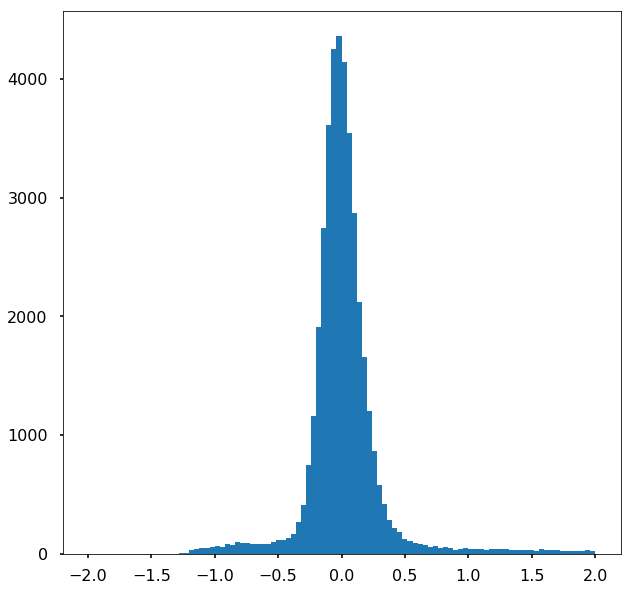

In [17]:
plt.hist(y,range=[-2,2],bins=100);

In [18]:
# data.genNjets2p5

In [19]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
kin_ev_inp (InputLayer)         (None, 9)            0                                            
__________________________________________________________________________________________________
kin_jets_inp (InputLayer)       (None, 6, 8)         0                                            
__________________________________________________________________________________________________
kin_ev_nb0 (BatchNormalization) (None, 9)            36          kin_ev_inp[0][0]                 
__________________________________________________________________________________________________
kin_jets_nb0 (BatchNormalizatio (None, 6, 8)         32          kin_jets_inp[0][0]               
__________________________________________________________________________________________________
kin_ev_jet

In [20]:
from keras.optimizers import Adam

In [21]:
# import bregnn.losses as losses

# opt = Adam(lr=1e-4)

# reload(losses)

# model.compile(optimizer=opt,loss=losses.gauss_nll)
# # model.compile(optimizer=opt,loss='mse')

In [22]:
from sklearn.model_selection import train_test_split

Xjets_train,Xjets_valid,Xev_train,Xev_valid,Xlinv_train,Xlinv_valid,y_train,y_valid,y0_train,y0_valid = train_test_split(Xjets,Xev,Xlinv,y,y0,test_size=0.1,random_state=12345)
X_train = [Xjets_train,Xev_train,Xlinv_train]
X_valid = [Xjets_valid,Xev_valid,Xlinv_valid]
# X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.05,random_state=12345)

In [ ]:
model.fit(X_train,y_train,batch_size=256,shuffle=True,validation_data=(X_valid,y_valid),epochs=200)

Train on 38328 samples, validate on 4259 samples
Epoch 1/200
38328/38328 [==============================] - 12s 301us/step - loss: 1.1153 - mse0: 2.1584 - mae0: 0.9794 - r2_score0: -1.6939 - val_loss: 0.3364 - val_mse0: 0.9300 - val_mae0: 0.3178 - val_r2_score0: -0.0103
Epoch 2/200
38328/38328 [==============================] - 7s 196us/step - loss: 0.7406 - mse0: 1.4964 - mae0: 0.7138 - r2_score0: -0.7004 - val_loss: 0.3227 - val_mse0: 0.9403 - val_mae0: 0.3051 - val_r2_score0: -0.0213
Epoch 3/200
38328/38328 [==============================] - 7s 194us/step - loss: 0.5605 - mse0: 1.2512 - mae0: 0.5651 - r2_score0: -0.3533 - val_loss: 0.3171 - val_mse0: 0.9432 - val_mae0: 0.3057 - val_r2_score0: -0.0248
Epoch 4/200
38328/38328 [==============================] - 8s 206us/step - loss: 0.4520 - mse0: 1.1380 - mae0: 0.4673 - r2_score0: -0.1666 - val_loss: 0.3116 - val_mse0: 0.9413 - val_mae0: 0.3064 - val_r2_score0: -0.0242
Epoch 5/200
38328/38328 [==============================] - 7s 192u

38328/38328 [==============================] - 8s 210us/step - loss: 0.3240 - mse0: 1.0042 - mae0: 0.3314 - r2_score0: 0.0040 - val_loss: 0.3001 - val_mse0: 0.9252 - val_mae0: 0.3106 - val_r2_score0: -0.0042
Epoch 38/200
38328/38328 [==============================] - 8s 208us/step - loss: 0.3241 - mse0: 1.0044 - mae0: 0.3316 - r2_score0: 0.0051 - val_loss: 0.3003 - val_mse0: 0.9279 - val_mae0: 0.3093 - val_r2_score0: -0.0079
Epoch 39/200
38328/38328 [==============================] - 8s 211us/step - loss: 0.3240 - mse0: 1.0031 - mae0: 0.3317 - r2_score0: 0.0044 - val_loss: 0.2998 - val_mse0: 0.9269 - val_mae0: 0.3089 - val_r2_score0: -0.0062
Epoch 40/200
38328/38328 [==============================] - 8s 204us/step - loss: 0.3239 - mse0: 1.0039 - mae0: 0.3315 - r2_score0: 0.0037 - val_loss: 0.2997 - val_mse0: 0.9244 - val_mae0: 0.3101 - val_r2_score0: -0.0022
Epoch 41/200
38328/38328 [==============================] - 8s 211us/step - loss: 0.3237 - mse0: 1.0013 - mae0: 0.3317 - r2_score

Epoch 74/200
38328/38328 [==============================] - 7s 192us/step - loss: 0.3048 - mse0: 0.8888 - mae0: 0.3221 - r2_score0: 0.1246 - val_loss: 0.3389 - val_mse0: 0.8142 - val_mae0: 0.3770 - val_r2_score0: 0.0335
Epoch 75/200
38328/38328 [==============================] - 8s 198us/step - loss: 0.3032 - mse0: 0.8807 - mae0: 0.3213 - r2_score0: 0.1355 - val_loss: 0.3775 - val_mse0: 0.9047 - val_mae0: 0.4173 - val_r2_score0: -0.1451
Epoch 76/200
38328/38328 [==============================] - 7s 194us/step - loss: 0.3039 - mse0: 0.8792 - mae0: 0.3216 - r2_score0: 0.1358 - val_loss: 0.3369 - val_mse0: 0.8138 - val_mae0: 0.3722 - val_r2_score0: 0.0231
Epoch 77/200
38328/38328 [==============================] - 8s 197us/step - loss: 0.3028 - mse0: 0.8767 - mae0: 0.3207 - r2_score0: 0.1325 - val_loss: 0.3433 - val_mse0: 0.8406 - val_mae0: 0.3807 - val_r2_score0: -0.0175
Epoch 78/200
38328/38328 [==============================] - 7s 191us/step - loss: 0.3029 - mse0: 0.8717 - mae0: 0.3214

38328/38328 [==============================] - 8s 201us/step - loss: 0.3006 - mse0: 0.8593 - mae0: 0.3198 - r2_score0: 0.1451 - val_loss: 0.3327 - val_mse0: 0.8176 - val_mae0: 0.3664 - val_r2_score0: 0.0314
Epoch 112/200
38328/38328 [==============================] - 7s 190us/step - loss: 0.2979 - mse0: 0.8440 - mae0: 0.3177 - r2_score0: 0.1660 - val_loss: 0.3077 - val_mse0: 0.7922 - val_mae0: 0.3368 - val_r2_score0: 0.0869
Epoch 113/200
38328/38328 [==============================] - 8s 196us/step - loss: 0.2993 - mse0: 0.8489 - mae0: 0.3188 - r2_score0: 0.1600 - val_loss: 0.3232 - val_mse0: 0.8465 - val_mae0: 0.3495 - val_r2_score0: 0.0234
Epoch 114/200
38328/38328 [==============================] - 7s 191us/step - loss: 0.2969 - mse0: 0.8374 - mae0: 0.3170 - r2_score0: 0.1693 - val_loss: 0.3034 - val_mse0: 0.7871 - val_mae0: 0.3326 - val_r2_score0: 0.0894
Epoch 115/200
38328/38328 [==============================] - 8s 196us/step - loss: 0.2958 - mse0: 0.8291 - mae0: 0.3158 - r2_score

In [ ]:
# print(X_train.shape,y_train.shape,X_valid.shape,y_valid.shape)

In [ ]:
# y_pred = model.predict(X_valid[:10000])

In [ ]:
# np.abs(y_pred[:,1]).min()

In [ ]:
# ( (y_valid[:10000] - y_pred[:10000,0])**2/y_pred[:10000,1]**2 ) .max()

In [ ]:
# reg.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=20)

In [ ]:
print(reg.model)

In [ ]:
print(model)

In [ ]:
y_pred = model.predict(X_valid)#,p0=False)

In [ ]:
plt.hist(y_pred[:,0],bins=100,range=[-1,1],histtype='step');

In [ ]:
# y_pred.shape
_,bins,_ = plt.hist(y_pred[:,0]-y_valid[:,0],bins=100,range=[-1,1],histtype='step');
plt.hist(y_valid[:,0],bins=bins,histtype='step');
#plt.hist(np.sqrt(y_valid[:,0]*y_std+y_mean),bins=bins,histtype='step');

In [ ]:
# y_pred_full = y_valid[:,0]
# plt.hist(y_pred_full,range=[-1,1])

In [ ]:
mass_valid = (y_valid[:,0] * y_std + y_mean)*np.sqrt(y0_valid)
mass_pred = (y_pred[:,0] * y_std + y_mean)*np.sqrt(y0_valid)
mass0_valid = np.sqrt(y0_valid)

In [ ]:
# mass_valid = np.sqrt(y_valid[:,0] * y_std + y_mean + y0_valid)
# mass_pred  = np.sqrt(y_pred[:,0] * y_std + y_mean + y0_valid)
# mass0_valid = np.sqrt(y0_valid)

In [ ]:
# y_pred0 = X['recoJet2p5Mass20'] + X['recoJet2p5Mass21'] + 2.*X['recoJet2p5P0P1']

In [ ]:
plt.hist(mass_pred / mass_valid -1., range=[-1,1], bins=100, histtype='step',normed=True);
plt.hist(mass0_valid / mass_valid -1., range=[-1,1], bins=100, histtype='step',normed=True);

In [ ]:
1. - (mass_pred / mass_valid).std() / (mass0_valid / mass_valid).std()

# plt.scatter(y_valid,y_pred[:,0])

In [ ]:
# plt.scatter(y_pred[:,0],np.abs(y_pred[:,1]));

In [ ]:
# y0_valid